# Game Analysis using Engine

In [1]:
import pandas as pd
import numpy as np
import chess.pgn
import io

%load_ext lab_black

In [2]:
df = pd.read_parquet("games/Caruana.parquet")

players = pd.Series(np.concatenate([df["Black"].values, df["White"].values]))

myplayer = players.value_counts().index[0]

df.loc[df["White"] == myplayer, "playing_as"] = "White"
df.loc[df["Black"] == myplayer, "playing_as"] = "Black"
messedup = df["playing_as"].isna().sum()
print(f"Number of messed up games {messedup}")
df_subset = (
    df.query("Online == False")
    .query("Date_clean >= 2021")
    .reset_index(drop=True)
    .copy()
)

Number of messed up games 3


# Stockfish 15

In [53]:
sf = "/home/robmulla/Downloads/stockfish_15_linux_x64/stockfish_15_src/src/stockfish"
from stockfish import Stockfish

stockfish = Stockfish(
    path=sf, depth=15, parameters={"Threads": 32, "Minimum Thinking Time": 5}
)

# Use stockfish to evaluate

In [54]:
from tqdm.notebook import tqdm

In [87]:
def get_game_corr(game, playing_as):
    board = game.board()
    n_moves = len([m for m in game.mainline_moves()])
    engine_cps = []
    played_cps = []
    top_moves = []
    played_moves = []
    for move in tqdm(game.mainline_moves(), total=n_moves):

        if playing_as == "White" and board.turn == True:
            stockfish.set_fen_position(board.fen())
            top = stockfish.get_top_moves(10)
            best_move = top[0]["Move"]
            best_centipawn = top[0]["Centipawn"]
            # White's move
            board.push(move)
            stockfish.set_fen_position(board.fen())
            evaluation = stockfish.get_evaluation()["value"]
            # print(f"{best_move}: {best_centipawn} - {move}: {evaluation}")
            top_moves.append(top)
            engine_cps.append(best_centipawn)
            played_cps.append(evaluation)
            played_moves.append(move)

        elif playing_as == "Black" and board.turn == False:
            # black's move
            stockfish.set_fen_position(board.fen())
            top = stockfish.get_top_moves(10)
            best_move = top[0]["Move"]
            best_centipawn = top[0]["Centipawn"]
            board.push(move)
            stockfish.set_fen_position(board.fen())
            evaluation = stockfish.get_evaluation()["value"]
            # print(f"{best_move}: {best_centipawn} - {move}: {evaluation}")
            top_moves.append(top)
            engine_cps.append(best_centipawn)
            played_cps.append(evaluation)
            played_moves.append(move)
        else:
            board.push(move)
    corr = np.corrcoef([engine_cps, played_cps])[1, 0]
    return top_moves, played_moves, engine_cps, played_cps, corr

In [56]:
for i, d in df_subset.iterrows():
    pgn = io.StringIO(d["mainline_moves"])
    game = chess.pgn.read_game(pgn)
    top_moves, played_moves, engine_cps, played_cps, corr = get_game_corr(
        game, playing_as=d["playing_as"]
    )
    print(d["Date"], d["Event"], d["Black"], d["White"], d["Result"], corr)
    break

0it [00:00, ?it/s]

2021.01.16 83rd Tata Steel Masters Van Foreest,Jorden Caruana,F 1/2-1/2 0.6850348581203665


In [57]:
engine_cps[11], played_cps[11]

(62, -31)

<AxesSubplot:>

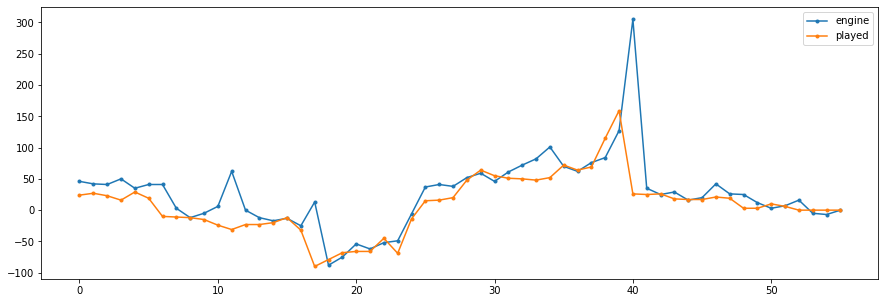

In [62]:
pd.DataFrame([engine_cps, played_cps]).T.rename(
    columns={0: "engine", 1: "played"}
).plot(figsize=(15, 5), style=".-")

In [63]:
pd.DataFrame([engine_cps, played_cps]).T.corr()[0][1]

0.6850348581203666

In [65]:
top_moves[40]

[{'Move': 'a3a8', 'Centipawn': 305, 'Mate': None},
 {'Move': 'a3a1', 'Centipawn': 173, 'Mate': None},
 {'Move': 'a3a7', 'Centipawn': 160, 'Mate': None},
 {'Move': 'a3a4', 'Centipawn': 152, 'Mate': None},
 {'Move': 'a3a5', 'Centipawn': 139, 'Mate': None},
 {'Move': 'g4g5', 'Centipawn': 124, 'Mate': None},
 {'Move': 'a3c3', 'Centipawn': 74, 'Mate': None},
 {'Move': 'g4f5', 'Centipawn': 62, 'Mate': None},
 {'Move': 'f4f5', 'Centipawn': 44, 'Mate': None},
 {'Move': 'g4h5', 'Centipawn': 20, 'Mate': None}]

In [39]:
played_cps[40]

313

In [38]:
played_moves[40]

Move.from_uci('f4f5')

# Run on Nieman

In [68]:
df = pd.read_parquet("games/Niemann.parquet")

players = pd.Series(np.concatenate([df["Black"].values, df["White"].values]))

myplayer = players.value_counts().index[0]

df.loc[df["White"] == myplayer, "playing_as"] = "White"
df.loc[df["Black"] == myplayer, "playing_as"] = "Black"
messedup = df["playing_as"].isna().sum()
print(f"Number of messed up games {messedup}")
df_subset = (
    df.query("Online == False")
    .query("Date_clean >= 2021")
    .reset_index(drop=True)
    .copy()
)

Number of messed up games 0


# FIND THE SUS GAME

In [75]:
sus_game = df.loc[df["Event"].str.contains("Shar") & (df["Round"] == "2")]

In [77]:
# sus_game

In [89]:
sf = "/home/robmulla/Downloads/stockfish_15_linux_x64/stockfish_15_src/src/stockfish"
from stockfish import Stockfish

stockfish = Stockfish(
    path=sf, depth=15, parameters={"Threads": 32, "Minimum Thinking Time": 5}
)

In [90]:
d = df.loc[1066]
pgn = io.StringIO(d["mainline_moves"])
game = chess.pgn.read_game(pgn)
top_moves, played_moves, engine_cps, played_cps, corr = get_game_corr(
    game, playing_as=d["playing_as"]
)
print(d["Date"], d["Event"], d["Black"], d["White"], d["Result"], corr)

  0%|          | 0/89 [00:00<?, ?it/s]

2021.09.18 Sharjah Masters 4th Rios, Cristhian Camilo Niemann, Hans Moke 1-0 0.9928594634874626


In [91]:
df_subset2 = df.loc[df["Event"].str.contains("Sharjah")]
for i, d in df_subset2.iterrows():
    pgn = io.StringIO(d["mainline_moves"])
    game = chess.pgn.read_game(pgn)
    top_moves, played_moves, engine_cps, played_cps, corr = get_game_corr(game, playing_as=d["playing_as"])
    print(d["Date"], d["Event"], d['Round'], d["Black"], d["White"], d["Result"], corr)

  0%|          | 0/27 [00:00<?, ?it/s]

2021.09.17 Sharjah Masters 4th 1 Niemann, Hans Moke Naiditsch, Arkadij 1/2-1/2 0.1257001526199132


  0%|          | 0/89 [00:00<?, ?it/s]

2021.09.18 Sharjah Masters 4th 2 Rios, Cristhian Camilo Niemann, Hans Moke 1-0 0.992192129285544


  0%|          | 0/61 [00:00<?, ?it/s]

2021.09.19 Sharjah Masters 4th 3 Niemann, Hans Moke Salem, AR Saleh 1-0 0.9827896246202426


  0%|          | 0/67 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [96]:
df_subset2.loc[1067]["mainline_moves"]

'1. d4 d5 2. c4 c6 3. Nc3 Nf6 4. Nf3 e6 5. g3 dxc4 6. Bg2 b5 7. Ne5 a6 8. O-O Bb7 9. b3 cxb3 10. axb3 Be7 11. Bb2 O-O 12. Ne4 Nd5 13. Nc5 Bxc5 14. dxc5 f6 15. Nd3 Nd7 16. e4 Nc7 17. Bc3 Qe7 18. Ba5 Rac8 19. f4 e5 20. f5 Rfd8 21. Qc2 g6 22. fxg6 hxg6 23. Bh3 Rf8 24. Rad1 Ne6 25. Bxe6+ Qxe6 26. Nf2 Rce8 27. Rd6 Qf7 28. Ng4 Qh7 29. Qd2 Bc8 30. Rxc6 Re7 31. Bd8'

In [97]:
df_subset2.loc[1067]

Annotator                                                         None
Black                                               Niemann, Hans Moke
BlackElo                                                          2609
BlackTeam                                                         None
BlackTeamCountry                                                  None
Date                                                        2021.09.19
ECO                                                                E04
Event                                              Sharjah Masters 4th
EventCategory                                                     None
EventCountry                                                       UAE
EventDate                                                   2021.09.17
EventRounds                                                          9
EventType                                                        swiss
PlyCount                                                            61
Result

<AxesSubplot:>

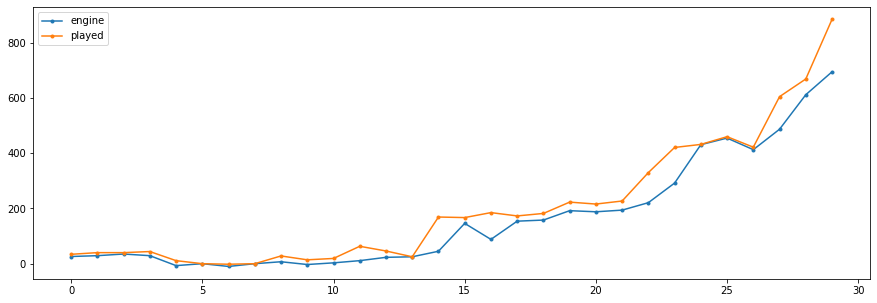

In [92]:
pd.DataFrame([engine_cps, played_cps]).T.rename(
    columns={0: "engine", 1: "played"}
).plot(figsize=(15, 5), style=".-")

In [84]:
df = pd.read_parquet("games/Carlsen.parquet")

players = pd.Series(np.concatenate([df["Black"].values, df["White"].values]))

myplayer = players.value_counts().index[0]

df.loc[df["White"] == myplayer, "playing_as"] = "White"
df.loc[df["Black"] == myplayer, "playing_as"] = "Black"
messedup = df["playing_as"].isna().sum()
print(f"Number of messed up games {messedup}")
df_subset = (
    df.query("Online == False")
    .query("Date_clean >= 2021")
    .reset_index(drop=True)
    .copy()
)

df_subset2 = df_subset.loc[df_subset["Event"].str.contains("Crypto")]
for i, d in df_subset2.iterrows():
    try:
        pgn = io.StringIO(d["mainline_moves"])
        game = chess.pgn.read_game(pgn)
        game_corr = get_game_corr(game, playing_as=d["playing_as"])
        print(
            d["Date"],
            d["Event"],
            d["Round"],
            d["Black"],
            d["White"],
            d["Result"],
            game_corr,
        )
    except:
        pass

Number of messed up games 9
2022.08.15 FTX Crypto Cup 2022 1.1 Carlsen,M Giri,A 1/2-1/2 0.9977407292056628
2022.08.15 FTX Crypto Cup 2022 1.2 Giri,A Carlsen,M 1/2-1/2 0.9947658685764633
2022.08.16 FTX Crypto Cup 2022 2.4 Carlsen,M Niemann,Hans Moke 0-1 0.9756421657004327
2022.08.16 FTX Crypto Cup 2022 2.3 Niemann,Hans Moke Carlsen,M 1-0 0.9972381721998715
2022.08.16 FTX Crypto Cup 2022 2.1 Niemann,Hans Moke Carlsen,M 0-1 0.9726440281938648
2022.08.16 FTX Crypto Cup 2022 2.2 Carlsen,M Niemann,Hans Moke 0-1 0.9544904044557002
2022.08.17 FTX Crypto Cup 2022 3.2 Aronian,L Carlsen,M 1/2-1/2 0.9952480915985473
2022.08.17 FTX Crypto Cup 2022 3.3 Carlsen,M Aronian,L 1/2-1/2 0.9639488602852254
2022.08.17 FTX Crypto Cup 2022 3.4 Aronian,L Carlsen,M 1/2-1/2 0.9989274556523078
2022.08.18 FTX Crypto Cup 2022 4.3 Le,Quang Liem Carlsen,M 1-0 0.9973151614431043
2022.08.18 FTX Crypto Cup 2022 4.2 Carlsen,M Le,Quang Liem 1/2-1/2 0.9939362860219867
2022.08.18 FTX Crypto Cup 2022 4.1 Le,Quang Liem Carlsen

In [85]:
df = pd.read_parquet("games/Niema.parquet")

players = pd.Series(np.concatenate([df["Black"].values, df["White"].values]))

myplayer = players.value_counts().index[0]

df.loc[df["White"] == myplayer, "playing_as"] = "White"
df.loc[df["Black"] == myplayer, "playing_as"] = "Black"
messedup = df["playing_as"].isna().sum()
print(f"Number of messed up games {messedup}")
df_subset = (
    df.query("Online == False")
    .query("Date_clean >= 2021")
    .reset_index(drop=True)
    .copy()
)

df_subset2 = df_subset.loc[df_subset["Event"].str.contains("Crypto")]
for i, d in df_subset2.iterrows():
    try:
        pgn = io.StringIO(d["mainline_moves"])
        game = chess.pgn.read_game(pgn)
        game_corr = get_game_corr(game, playing_as=d["playing_as"])
        print(
            d["Date"],
            d["Event"],
            d["Round"],
            d["Black"],
            d["White"],
            d["Result"],
            game_corr,
        )
    except:
        pass

Number of messed up games 0
2022.08.15 Miami FTX Crypto Cup 1.1 Duda, Jan Krzysztof Niemann, Hans Moke 1-0 0.9509173700507729
2022.08.15 Miami FTX Crypto Cup 1.2 Niemann, Hans Moke Duda, Jan Krzysztof 1-0 0.9901993908298921
2022.08.15 Miami FTX Crypto Cup 1.3 Duda, Jan Krzysztof Niemann, Hans Moke 0-1 0.9770584427474743
2022.08.16 Miami FTX Crypto Cup 2.1 Niemann, Hans Moke Carlsen, Magnus 0-1 0.9983603699858093
2022.08.16 Miami FTX Crypto Cup 2.2 Carlsen, Magnus Niemann, Hans Moke 0-1 0.9967737924297568
2022.08.16 Miami FTX Crypto Cup 2.3 Niemann, Hans Moke Carlsen, Magnus 1-0 0.9985035419278069
2022.08.16 Miami FTX Crypto Cup 2.4 Carlsen, Magnus Niemann, Hans Moke 0-1 0.9888505203038584
2022.08.17 Miami FTX Crypto Cup 3.4 Niemann, Hans Moke Praggnanandhaa, Rameshbabu 1-0 0.9849827300129371
2022.08.17 Miami FTX Crypto Cup 3.1 Praggnanandhaa, Rameshbabu Niemann, Hans Moke 1-0 0.9978332622513577
2022.08.17 Miami FTX Crypto Cup 3.2 Niemann, Hans Moke Praggnanandhaa, Rameshbabu 1-0 0.9646

# Questionable Game

In [124]:
stockfish = Stockfish(
    path=sf, depth=12, parameters={"Threads": 32, "Minimum Thinking Time": 5}
)

d = df_subset.loc[317]
pgn = io.StringIO(d["mainline_moves"])
game = chess.pgn.read_game(pgn)
top_moves, played_moves, engine_cps, played_cps, corr = get_game_corr(
    game, playing_as=d["playing_as"]
)

<AxesSubplot:>

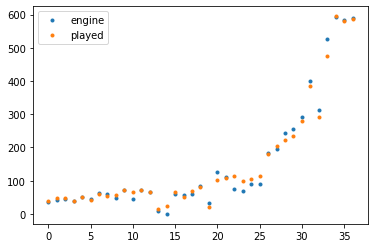

In [125]:
pd.DataFrame([played_cps, engine_cps]).T.rename(
    columns={0: "engine", 1: "played"}
).plot(style=".")

In [161]:
i = 22
played_moves[i], engine_cps[i], played_cps[i], top_moves[i]

(Move.from_uci('h6g7'),
 115,
 76,
 [{'Move': 'h6g7', 'Centipawn': 115, 'Mate': None},
  {'Move': 'd1h1', 'Centipawn': 53, 'Mate': None},
  {'Move': 'c3e2', 'Centipawn': 37, 'Mate': None},
  {'Move': 'd1e1', 'Centipawn': 31, 'Mate': None},
  {'Move': 'h6h7', 'Centipawn': -10, 'Mate': None},
  {'Move': 'c3b1', 'Centipawn': -13, 'Mate': None},
  {'Move': 'd1f1', 'Centipawn': -18, 'Mate': None},
  {'Move': 'c3a4', 'Centipawn': -23, 'Mate': None},
  {'Move': 'c1c2', 'Centipawn': -24, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -59, 'Mate': None}])

In [166]:
played_cps[22]

76

In [136]:
played_moves[13]

Move.from_uci('f2f4')

<Game at 0x7f59bbe092e0 ('?' vs. '?', '????.??.??')>